In [21]:
N = ord('A') % 5 + 1
print(N)

1


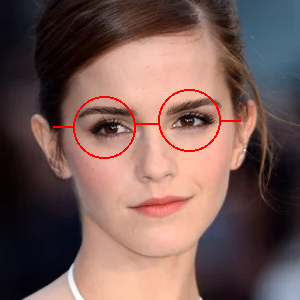

In [29]:
import os
import pandas as pd
import cv2
from PIL import Image, ImageDraw
from IPython.display import display

# Функція для завантаження даних з Excel-файлу
def load_data(file_path, variant):
    df = pd.read_excel(file_path)
    data = df.iloc[variant - 1]
    return data

# Функція для отримання кольору в форматі RGB за назвою
def color_from_string(color_name):
    # Визначаємо кольори у форматі RGB
    colors = {
        'red': (255, 0, 0),
        'blue': (0, 0, 255),
        'cian': (0, 255, 255),
        'magenta': (255, 0, 255),
        'yellow': (255, 255, 0),
    }
    
    return colors.get(color_name.lower(), (0, 0, 0))

# Функція для обрізки зображення
def crop_around_face(img, face_center, target_size):
    img_width, img_height = img.size
    target_width, target_height = target_size
    
    left = max(face_center[0] - target_width // 2, 0)
    top = max(face_center[1] - target_height // 2, 0)
    right = min(face_center[0] + target_width // 2, img_width)
    bottom = min(face_center[1] + target_height // 2, img_height)
    
    if right - left < target_width:
        if left == 0:
            right = target_width
        else:
            left = img_width - target_width
    if bottom - top < target_height:
        if top == 0:
            bottom = target_height
        else:
            top = img_height - target_height

    return img.crop((left, top, right, bottom))

# Функція для додавання окулярів на обличчя
def add_glasses(image_path, output_path, color=(0, 0, 255), thickness=3, target_size=(300, 300)):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        print("Обличчя не виявлено")
        return

    (x, y, w, h) = faces[0]
    face_center = (x + w // 2, y + h // 2)

    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    pil_image = crop_around_face(pil_image, face_center, target_size)

    face_center = (target_size[0] // 2, target_size[1] // 2)

    # Пошук очей
    roi_gray = gray[y:y + h // 2, x:x + w]
    eyes = eye_cascade.detectMultiScale(roi_gray)

    eye_positions = []
    for (ex, ey, ew, eh) in eyes:
        eye_center = (face_center[0] + (ex + ew // 2 - w // 2), face_center[1] + (ey + eh // 2 - h // 2))
        eye_positions.append(eye_center)

    if len(eye_positions) >= 2:
        eye_positions = sorted(eye_positions, key=lambda pos: pos[0])
        left_eye, right_eye = eye_positions[:2]

        draw = ImageDraw.Draw(pil_image)

        eye_distance = right_eye[0] - left_eye[0]
        eye_radius = eye_distance // 2.7

        # Малюємо рамки окулярів
        draw.ellipse((left_eye[0] - eye_radius, left_eye[1] - eye_radius, left_eye[0] + eye_radius, left_eye[1] + eye_radius), outline=color, width=thickness)
        draw.ellipse((right_eye[0] - eye_radius, right_eye[1] - eye_radius, right_eye[0] + eye_radius, right_eye[1] + eye_radius), outline=color, width=thickness)

        # Малюємо перенісся
        bridge_y = (left_eye[1] + right_eye[1]) // 2
        draw.line((left_eye[0] + eye_radius, bridge_y, right_eye[0] - eye_radius, bridge_y), fill=color, width=thickness)

        # Малюємо дужки окулярів
        draw.line((left_eye[0] - eye_radius, left_eye[1], left_eye[0] - eye_radius - 20, left_eye[1]), fill=color, width=thickness)
        draw.line((right_eye[0] + eye_radius, right_eye[1], right_eye[0] + eye_radius + 20, right_eye[1]), fill=color, width=thickness)

    # Зберігаємо зображення з окулярами та показуємо його
    pil_image.save(output_path)
    display(pil_image)

file_path = "C:\\Users\\Forze\\lab5.xlsx"
variant = 1
data = load_data(file_path, variant)

image_name = data['file name']
color = color_from_string(data['glasses color'])
thickness = int(data['line width'])
target_size_str = data['image size']
target_size = tuple(map(int, target_size_str.split('x')))

image_folder = "C:\\Users\\Forze\\Images"
output_folder = "C:\\Users\\Forze\\Output"
os.makedirs(output_folder, exist_ok=True)

image_path = os.path.join(image_folder, image_name)
output_path = os.path.join(output_folder, f"glasses_{image_name}")

add_glasses(image_path, output_path, color=color, thickness=thickness, target_size=target_size)
